In [1]:
import anndata as ad
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import json


In [2]:
#get system variable
data_dir = os.environ.get('ROOT_DATA_PATH')

#load data
adata = ad.read_h5ad(os.path.join(data_dir, 'barseq/Chen2023/filt_neurons_D076_1L_CCFv2_newtypes.h5ad'), backed='r')

In [3]:
adata

AnnData object with n_obs × n_vars = 1002996 × 106 backed at '/home/benjami/mnt/zador_data_norepl/Ari/transcriptomics/barseq/Chen2023/filt_neurons_D076_1L_CCFv2_newtypes.h5ad'
    obs: 'angle', 'H1_type', 'CCFname', 'slice', 'CCFparentname', 'id', 'H2_type', 'CCFano', 'H3_type'
    uns: 'H2_type_id', 'H3_type_id', 'brain_idx', 'genes', 'slices_to_remove'
    obsm: 'CCF', 'CCF_streamlines', 'depth', 'pos', 'pos40x'

In [4]:
adata.obs['CCFano'] = adata.obs['CCFano'].astype('category')

adata.obs['CFFname'] = adata.obs['CCFname'].astype('category')
adata.obs['CFFname'].cat.categories

Index(['AAA', 'ACAd1', 'ACAd2/3', 'ACAd5', 'ACAd6a', 'ACAd6b', 'ACAv1',
       'ACAv2/3', 'ACAv5', 'ACAv6a',
       ...
       'sctv', 'scwm', 'sm', 'sptV', 'st', 'stc', 'sup', 'tb', 'tspc', 'vhc'],
      dtype='object', length=508)

Text(0.5, 1.0, 'Finest CCF Annotations')

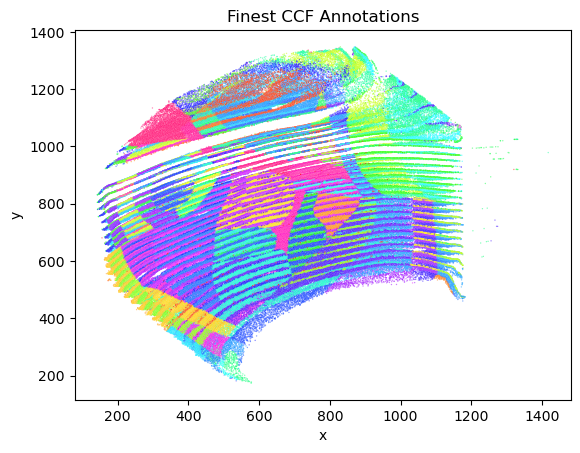

In [5]:

df = pd.DataFrame(adata.obsm['CCF_streamlines'], columns=['x', 'y','z'])
df['CCFano'] = adata.obs['CCFano'].values
sns.scatterplot(df, x='x', y='y', hue='CCFano', palette='hsv', alpha=0.5, s=1)
plt.legend('', frameon=False)
plt.title("Finest CCF Annotations")

In [6]:
# move up the hierarchy to get rid of the smallest 'areas' which are actually layers
with open('files/area_ancestor_id_map.json', 'r') as f:
    area_ancestor_id_map = json.load(f)
with open('files/area_name_map.json', 'r') as f:
    area_name_map = json.load(f)
area_name_map['0'] = 'outside_brain'
annotation2area_int = {0.0:0} # Map from annotation id to area id. Float to int
for a in area_ancestor_id_map.keys(): 
    higher_area_id = area_ancestor_id_map[str(int(a))][1] if len(area_ancestor_id_map[str(int(a))])>1 else a    
    annotation2area_int[float(a)] = higher_area_id

unique_areas = np.unique(list(annotation2area_int.values())) # List of unique areas (noncontiguous ints)
unique_annos = [area_name_map[str(int(a))] for a in unique_areas] # List of unique area names
area_classes = np.arange(len(unique_areas)) # Create a class for each area (0, 1, 2, ...)
id2id = {float(k):v for (k,v) in zip(unique_areas, area_classes)} # Map from area id to class id
annoation2area_class = {k: id2id[int(v)] for k,v in annotation2area_int.items()} # Map from annotation to area class
id2id_rev = {v:k for k,v in id2id.items()} # Map from class id to area id
area_class2area_name = {k: area_name_map[str(int(v))] for k,v in id2id_rev.items()} # Map from area class to area name



In [7]:
adata.obs['area_label'] = adata.obs['CCFano'].map(annoation2area_class).astype('category')
adata.obs['area_class'] = adata.obs['area_label'].map(area_class2area_name).astype('category')


adata.obs[['area_label', 'area_class']].head()

,area_label,area_class
9,260,"Entorhinal area, medial part, dorsal zone"
10,260,"Entorhinal area, medial part, dorsal zone"
12,260,"Entorhinal area, medial part, dorsal zone"
15,260,"Entorhinal area, medial part, dorsal zone"
18,260,"Entorhinal area, medial part, dorsal zone"


Text(0.5, 1.0, 'Areas of the CCF')

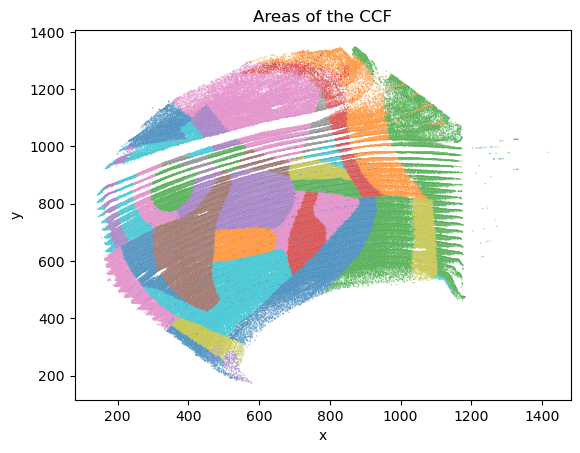

In [8]:
# color_idx = adata.obs['CCFano'].cat.categories.tolist().index(batch['CCFano'].cpu().numpy()[0])
# color = sns.color_palette("hsv", len(adata.obs['CCFano'].cat.categories))[color_idx]
df['area_label'] = adata.obs['area_label'].values
sns.scatterplot(df, x='x', y='y', hue='area_label', palette='tab10', alpha=0.5, s=1)
plt.legend('', frameon=False)
plt.title("Areas of the CCF")

In [9]:
num_areas = len(adata.obs['area_label'].cat.categories)
num_areas

144

In [11]:
from datasets import load_from_disk
from transformers import TrainingArguments, PreTrainedModel, AutoConfig
import torch
import matplotlib.pyplot as plt
import numpy as np
from typing import Dict

import sys 
sys.path.append('..')
from samplers import MultiformerTrainer

import torch
import torch.distributed as dist
from torch.utils.data import Sampler, Dataset
import numpy as np
import math

from typing import Iterator, List, Optional, Tuple
from dataclasses import dataclass
from transformers import Trainer

from dataclasses import dataclass
from typing import Dict, List, Optional, Union
import torch
from collections import Counter
import collections

# Dummy model for testing
class NullModel(PreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.dummy_param = torch.nn.Parameter(torch.zeros(1))
    
    def forward(self, **kwargs):
        return None

# Load dataset and create trainer
def create_test_trainer(dataset_path: str, group_size: int = 32, window_size: float = 0.1):
    # Load dataset
    dataset = load_from_disk(dataset_path)
    
    # Create minimal training arguments
    training_args = TrainingArguments(
        output_dir="./test_trainer",
        per_device_train_batch_size=1,  # Since each "example" is a group
        num_train_epochs=1,
        remove_unused_columns=False,
    )
    
    # Create dummy model
    config = AutoConfig.from_pretrained("bert-base-uncased")
    model = NullModel(config)
    
    # Create trainer
    trainer = MultiformerTrainer(
        model=model,
        args=training_args,
        train_dataset=dataset["train"],
        spatial_group_size=group_size,
        spatial_window_size=window_size,
        spatial_label_key="CCFano"  # Adjust if your label key is different
    )
    
    return trainer, dataset

# Function to examine a batch
def print_batch_info(batch: Dict[str, torch.Tensor]):
    print("\nBatch Structure:")
    for key, value in batch.items():
        if isinstance(value, torch.Tensor):
            print(f"{key}: shape {value.shape}, dtype {value.dtype}")
    
    num_groups = batch["input_ids"].shape[0]
    print(f"\nNumber of groups in batch: {num_groups}")
    print(f"Number of sentences per group: {batch['input_ids'].shape[1]}")

# Function to visualize spatial groups
def plot_spatial_groups(dataset, batch_indices, group_size: int, num_examples: int = 4):
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))
    axes = axes.ravel()
    
    # Create colormap for labels
    unique_labels = np.unique([dataset[idx]["labels"] for idx in batch_indices[:group_size*num_examples]])
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
    label_to_color = dict(zip(unique_labels, colors))
    
    for i in range(num_examples):
        ax = axes[i]
        start_idx = i * group_size
        end_idx = start_idx + group_size
        group_indices = batch_indices[start_idx:end_idx]
        
        # Get coordinates and labels
        coordinates = np.array([dataset[idx]["CCF_streamlines"] for idx in group_indices])
        labels = np.array([dataset[idx]["labels"] for idx in group_indices])
        
        # Get majority label for color
        unique, counts = np.unique(labels, return_counts=True)
        majority_label = unique[np.argmax(counts)]
        
        # Plot points
        ax.scatter(coordinates[:, 0], coordinates[:, 1], 
                  color=label_to_color[majority_label],
                  alpha=0.6, s=100)
        
        # Plot centroid
        centroid = coordinates.mean(axis=0)
        ax.scatter(centroid[0], centroid[1], color='black', marker='*', s=200,
                  label=f'Centroid (Label: {majority_label})')
        
        ax.set_title(f'Group {i+1}')
        ax.legend()
        ax.grid(True)
    
    plt.tight_layout()
    return fig

# Test the setup
def test_spatial_sampling(dataset_path: str):
    # Create trainer
    trainer, dataset = create_test_trainer(dataset_path)
    
    # Get dataloader
    train_dataloader = trainer.get_train_dataloader()
    
    # Get one batch and print info
    batch = next(iter(train_dataloader))
    print_batch_info(batch)
    
    # Get indices from sampler for visualization
    sampler_indices = list(trainer.train_dataset.sampler)
    
    # Plot some examples
    fig = plot_spatial_groups(dataset["train"], sampler_indices, 
                            group_size=trainer.spatial_group_size)
    
    return fig



In [12]:


@dataclass
class PrecomputedData:
    """Container for precomputed spatial data"""
    coordinates: np.ndarray
    x_sorted: np.ndarray
    y_sorted: np.ndarray
    x_sorted_indices: np.ndarray
    y_sorted_indices: np.ndarray
    x_range: float
    y_range: float
    window_width: float
    window_height: float

class SpatialGroupSampler(Sampler):
    """
    Sampler that groups sentences based on spatial proximity in 2D space.
    
    Each "example" in the resulting batch is actually a group of sentences that are
    spatially close to each other. The groups are selected dynamically during iteration.
    
    Args:
        dataset: HuggingFace dataset containing spatial coordinates
        batch_size: Number of examples (groups) per batch
        group_size: Number of sentences per group
        coordinate_key: Key in dataset for accessing spatial coordinates
        window_size: Size of spatial window for neighbor search (relative to total space)
        seed: Random seed for reproducibility
    """
    def __init__(
        self,
        dataset: Dataset,
        batch_size: int,
        group_size: int = 32,
        coordinate_key: str = "CCF_streamlines",
        window_size: float = 0.1,
        seed: int = 0,
    ):
        self.dataset = dataset
        self.batch_size = batch_size
        self.group_size = group_size
        self.coordinate_key = coordinate_key
        self.window_size = window_size
        self.seed = seed
        self.epoch = 0
        
        # Calculate sizes
        self.num_samples = len(dataset)
        self.rng = np.random.RandomState(seed)
        
        # Precompute spatial data
        self.precomputed = self._precompute_spatial_data()

    def _precompute_spatial_data(self) -> PrecomputedData:
        """Precompute spatial data structures for efficient neighbor search."""
        print("Precomputing spatial data...")
        coordinates = np.array([
            self.dataset[i][self.coordinate_key] for i in range(len(self.dataset))
        ])
        
        x_sorted_indices = np.argsort(coordinates[:, 0])
        y_sorted_indices = np.argsort(coordinates[:, 1])
        
        x_sorted = coordinates[x_sorted_indices, 0]
        y_sorted = coordinates[y_sorted_indices, 1]
        
        x_min, x_max = x_sorted[0], x_sorted[-1]
        y_min, y_max = y_sorted[0], y_sorted[-1]

        print("Indexing complete.")
        
        return PrecomputedData(
            coordinates=coordinates,
            x_sorted=x_sorted,
            y_sorted=y_sorted,
            x_sorted_indices=x_sorted_indices,
            y_sorted_indices=y_sorted_indices,
            x_range=x_max - x_min,
            y_range=y_max - y_min,
            window_width=self.window_size * (x_max - x_min),
            window_height=self.window_size * (y_max - y_min)
        )

    def _get_spatial_group(self, center_idx: int) -> np.ndarray:
        """Get indices for one spatial group. First finds neighbors in a window, then selects the closest."""
        
        center = self.precomputed.coordinates[center_idx]
        
        # Find points in window using precomputed arrays
        x_min = center[0] - self.precomputed.window_width / 2
        x_max = center[0] + self.precomputed.window_width / 2
        y_min = center[1] - self.precomputed.window_height / 2
        y_max = center[1] + self.precomputed.window_height / 2
        
        x_start = np.searchsorted(self.precomputed.x_sorted, x_min)
        x_end = np.searchsorted(self.precomputed.x_sorted, x_max, side='right')
        y_start = np.searchsorted(self.precomputed.y_sorted, y_min)
        y_end = np.searchsorted(self.precomputed.y_sorted, y_max, side='right')
        
        x_indices = self.precomputed.x_sorted_indices[x_start:x_end]
        y_indices = self.precomputed.y_sorted_indices[y_start:y_end]
        
        window_indices = np.intersect1d(x_indices, y_indices)
        
        if len(window_indices) == 0:
            return self.rng.choice(len(self.dataset), size=self.group_size, replace=False)

        assert self.group_size <= len(window_indices), "Not enough neighbors found. Increase window size."
            
        distances = np.sum((self.precomputed.coordinates[window_indices] - center) ** 2, axis=1)
        k = min(self.group_size, len(window_indices))
        nearest_idx = np.argpartition(distances, k)[:k]
        
        group = window_indices[nearest_idx]
        
        if len(group) < self.group_size:
            remaining = self.group_size - len(group)
            available = np.setdiff1d(np.arange(len(self.dataset)), group)
            pad_indices = self.rng.choice(available, size=remaining, replace=False)
            group = np.concatenate([group, pad_indices])
            
        return group

    def __iter__(self) -> Iterator[int]:
        """Returns iterator of indices where spatial groups are kept together."""
        g = torch.Generator()
        g.manual_seed(self.seed + self.epoch)
        
        # Generate all indices maintaining group structure
        all_indices = []
        num_complete_groups = self.num_samples // self.group_size
        
        for _ in range(num_complete_groups):
            center_idx = self.rng.randint(0, len(self.dataset))
            group = self._get_spatial_group(center_idx)
            all_indices.extend(group)
        
        # Handle remaining indices if any
        remaining = self.num_samples - len(all_indices)
        if remaining > 0:
            center_idx = self.rng.randint(0, len(self.dataset))
            last_group = self._get_spatial_group(center_idx)
            all_indices.extend(last_group[:remaining])
            
        return iter(all_indices)

    def __len__(self) -> int:
        return self.num_samples

    def set_epoch(self, epoch: int) -> None:
        """Sets the epoch for this sampler."""
        self.epoch = epoch


class DistributedSpatialGroupSampler(Sampler):
    """
    Distributed version of SpatialGroupSampler for multi-GPU training.
    
    Handles proper sharding of data across multiple GPUs while maintaining
    the spatial grouping of sentences.
    
    Args:
        dataset: HuggingFace dataset containing spatial coordinates
        batch_size: Number of examples (groups) per batch
        num_replicas: Number of training processes (defaults to world_size)
        rank: Process rank (defaults to current rank)
        group_size: Number of sentences per group
        coordinate_key: Key in dataset for accessing spatial coordinates
        window_size: Size of spatial window for neighbor search (relative to total space)
        seed: Random seed for reproducibility
        drop_last: Whether to drop last incomplete batch
    """
    def __init__(
        self,
        dataset: Dataset,
        batch_size: int,
        num_replicas: Optional[int] = None,
        rank: Optional[int] = None,
        seed: int = 0,
        drop_last: bool = False,
        group_size: int = 32,
        coordinate_key: str = "CCF_streamlines",
        window_size: float = 0.1,
    ):
        if num_replicas is None:
            if not dist.is_available():
                raise RuntimeError("Requires distributed package to be available")
            num_replicas = dist.get_world_size()
        if rank is None:
            if not dist.is_available():
                raise RuntimeError("Requires distributed package to be available")
            rank = dist.get_rank()

        self.dataset = dataset
        self.batch_size = batch_size
        self.num_replicas = num_replicas
        self.rank = rank
        self.epoch = 0
        self.drop_last = drop_last
        self.group_size = group_size
        self.coordinate_key = coordinate_key
        self.window_size = window_size

        # Calculate sizes for distributed sampling
        if self.drop_last and len(self.dataset) % self.num_replicas != 0:
            self.num_samples = math.ceil(
                (len(self.dataset) - self.num_replicas) / self.num_replicas
            )
        else:
            self.num_samples = math.ceil(len(self.dataset) / self.num_replicas)
            
        self.total_size = self.num_samples * self.num_replicas
        self.seed = seed
        self.rng = np.random.RandomState(seed)
        
        # Precompute spatial data
        self.precomputed = self._precompute_spatial_data()
        
    # Reuse methods from SpatialGroupSampler
    _precompute_spatial_data = SpatialGroupSampler._precompute_spatial_data
    _get_spatial_group = SpatialGroupSampler._get_spatial_group

    def __iter__(self) -> Iterator[int]:
        """Returns distributed iterator of indices where spatial groups are kept together."""
        g = torch.Generator()
        g.manual_seed(self.seed + self.epoch)
        
        # Generate all groups first
        all_indices = []
        num_complete_groups = self.total_size // self.group_size
        
        for _ in range(num_complete_groups):
            center_idx = self.rng.randint(0, len(self.dataset))
            group = self._get_spatial_group(center_idx)
            all_indices.extend(group)
            
        # Handle remaining indices if needed
        remaining = self.total_size - len(all_indices)
        if remaining > 0 and not self.drop_last:
            center_idx = self.rng.randint(0, len(self.dataset))
            last_group = self._get_spatial_group(center_idx)
            all_indices.extend(last_group[:remaining])
        
        assert len(all_indices) == self.total_size, \
            f"Expected {self.total_size} indices but got {len(all_indices)}"
            
        # Subsample indices for this worker
        indices = all_indices[self.rank:self.total_size:self.num_replicas]
        assert len(indices) == self.num_samples
        
        return iter(indices)

    def __len__(self) -> int:
        return self.num_samples

    def set_epoch(self, epoch: int) -> None:
        """Sets the epoch for this sampler."""
        self.epoch = epoch

@dataclass
class SpatialGroupCollator:
    """
    Collator that handles both grouping of spatially-related sentences and their labels.
    Handles partial batches gracefully.
    """
    group_size: int
    label_key: str
    feature_keys: Optional[List[str]] = None
    pad_token_id: int = 0
    padding: str = "max_length"
    
    def __post_init__(self):
        if self.feature_keys is None:
            self.feature_keys = ["input_ids"]

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        """
        Group features into spatial groups and aggregate their labels.
        Handles partial batches (when len(features) < group_size).
        """
        if not features:
            return {}
            
        # Handle case where we have fewer features than group_size
        num_features = len(features)
        if num_features < self.group_size:
            # Pad the features list with copies of the last feature
            padding_needed = self.group_size - num_features
            features.extend([features[-1]] * padding_needed)
            print("Warning: Padding features to meet group size.")
            print(f"Original number of features: {num_features}, padded to: {len(features)}")
            
        # Calculate number of complete groups
        num_groups = len(features) // self.group_size
        grouped_features = []
        
        for group_idx in range(num_groups):
            start_idx = group_idx * self.group_size
            end_idx = start_idx + self.group_size
            group = features[start_idx:end_idx]
            
            # Collect features for this group
            group_dict = {key: [] for key in self.feature_keys}
            group_labels = []
            
            for item in group:
                # Collect all features except labels
                for key in self.feature_keys:
                    tensor = item[key]
                    if not isinstance(tensor, torch.Tensor):
                        tensor = torch.tensor(tensor)
                    group_dict[key].append(tensor)
                
                # Collect labels separately
                label = item[self.label_key]
                if not isinstance(label, torch.Tensor):
                    label = torch.tensor(label)
                group_labels.append(label)
            
            # Stack features
            for key in self.feature_keys:
                # Find max length in this group
                max_len = max(x.size(-1) for x in group_dict[key])
                
                # Pad each tensor to max length
                padded = []
                for tensor in group_dict[key]:
                    if tensor.size(-1) < max_len:
                        padding = torch.full(
                            (max_len - tensor.size(-1),),
                            self.pad_token_id,
                            dtype=tensor.dtype
                        )
                        tensor = torch.cat([tensor, padding])
                    padded.append(tensor)
                
                group_dict[key] = torch.stack(padded)
            
            # Aggregate labels for the group (majority vote)
            group_labels = torch.stack(group_labels)

            # For classification, use mode
            label_counts = Counter(group_labels.tolist())
            majority_label = label_counts.most_common(1)[0][0]
            group_dict[self.label_key] = torch.tensor(majority_label)
            
            grouped_features.append(group_dict)
        
        if not grouped_features:
            return {}
            
        # Combine all groups into final batch
        batch = {
            key: torch.stack([group[key] for group in grouped_features])
            for key in grouped_features[0].keys()
        }
        
        return batch

class MultiformerTrainer(Trainer):
    def __init__(self, *args, additional_attributes=None, 
                 spatial_group_size=32, spatial_window_size=0.1,
                 spatial_label_key='CCFano', **kwargs):
        kwargs["data_collator"] = SpatialGroupCollator(
            group_size=spatial_group_size,
            label_key=spatial_label_key,
            feature_keys=["input_ids", "CCF_streamlines"],  # Add other feature keys as needed
            pad_token_id=0 # Adjust as needed
        )
        # Store spatial sampling parameters
        self.spatial_group_size = spatial_group_size
        self.spatial_window_size = spatial_window_size
        
        super().__init__(*args, **kwargs)

        assert self.args.train_batch_size % spatial_group_size == 0, \
            "train_batch_size must be divisible by spatial_group_size"

    def _get_train_sampler(self) -> Optional[torch.utils.data.sampler.Sampler]:
        if not isinstance(self.train_dataset, collections.abc.Sized):
            return None

        generator = None
        if self.args.world_size <= 1:
            generator = torch.Generator()
            generator.manual_seed(
                int(torch.empty((), dtype=torch.int64).random_().item())
            )

        # Build the sampler.
        # Use spatial sampling
        if self.args.world_size <= 1:
            return SpatialGroupSampler(
                dataset=self.train_dataset,
                batch_size=self.args.train_batch_size,
                group_size=self.spatial_group_size,
                window_size=self.spatial_window_size,
                seed=self.args.seed
            )
        else:
            return DistributedSpatialGroupSampler(
                dataset=self.train_dataset,
                batch_size=self.args.train_batch_size,
                num_replicas=self.args.world_size,
                rank=self.args.process_index,
                seed=self.args.seed,
                group_size=self.spatial_group_size,
                window_size=self.spatial_window_size
            )

    def _get_eval_sampler(self, eval_dataset) -> Optional[torch.utils.data.sampler.Sampler]:
        if not isinstance(eval_dataset, collections.abc.Sized):
            return None

        generator = None
        if self.args.world_size <= 1:
            generator = torch.Generator()
            generator.manual_seed(
                int(torch.empty((), dtype=torch.int64).random_().item())
            )

        # Build the sampler.
        # Use spatial sampling for evaluation
        if self.args.world_size <= 1:
            return SpatialGroupSampler(
                dataset=eval_dataset,
                batch_size=self.args.eval_batch_size,
                group_size=self.spatial_group_size,
                window_size=self.spatial_window_size,
                seed=self.args.seed
            )
        else:
            return DistributedSpatialGroupSampler(
                dataset=eval_dataset,
                batch_size=self.args.eval_batch_size,
                num_replicas=self.args.world_size,
                rank=self.args.process_index,
                seed=self.args.seed,
                group_size=self.spatial_group_size,
                window_size=self.spatial_window_size
            )
        
## Usage Example

# # For single GPU training:
# sampler = SpatialGroupSampler(
#     dataset=dataset,
#     batch_size=64,
#     group_size=32,
#     window_size=0.1
# )

# # For distributed training:
# sampler = DistributedSpatialGroupSampler(
#     dataset=dataset,
#     batch_size=64,
#     group_size=32,
#     window_size=0.1,
#     num_replicas=dist.get_world_size(),
#     rank=dist.get_rank()
# )

# # Use with DataLoader
# dataloader = DataLoader(
#     dataset,
#     batch_size=None,  # Controlled by sampler
#     sampler=sampler,
#     collate_fn=spatial_collate_fn
# )

In [13]:
dataset_path = "/home/benjami/brain-annotation/data/train_test_barseq.dataset"  # Replace with your dataset path

dataset = load_from_disk(dataset_path)

# Create minimal training arguments
training_args = TrainingArguments(
output_dir="./test_trainer",
num_train_epochs=1,
remove_unused_columns=False,
per_device_train_batch_size=32
)

# Create dummy model
config = AutoConfig.from_pretrained("bert-base-uncased")
model = NullModel(config)


group_size = 32
window_size = 0.01

# Create trainer
trainer = MultiformerTrainer(
model=model,
args=training_args,
train_dataset=dataset["train"],
spatial_group_size=group_size,
spatial_window_size=window_size,
spatial_label_key="CCFano",  # Adjust if your label key is different
)

In [14]:
# subselect data for testing
train_dataset_subset = dataset["train"].select(range(200000))
train_dataset_subset = train_dataset_subset.filter(lambda x: not np.isnan(np.sum(x['CCF_streamlines'])))
train_dataset_subset

Filter:   0%|          | 0/200000 [00:00<?, ? examples/s]

Dataset({
    features: ['input_ids', 'id', 'H2_type', 'CCF_streamlines', 'CCFparentname', 'CCF', 'CCFname', 'H1_type', 'CCFano', 'H3_type', 'length', 'area_label'],
    num_rows: 200000
})

In [16]:
np.unique(train_dataset_subset['area_label'])

array([  0,   5,   8,  12,  15,  79,  80, 110, 117, 120, 121, 123, 159,
       161, 210, 212, 227, 243, 246, 248, 249, 250, 259, 273])

In [20]:
# create new column with map using the annoation2area_class mapping
train_dataset_subset = train_dataset_subset.map(lambda x: {'area_label': annoation2area_class[x['CCFano']]})
train_dataset_subset

Dataset({
    features: ['input_ids', 'CCFparentname', 'id', 'CCFname', 'H1_type', 'H3_type', 'CCF_streamlines', 'H2_type', 'CCFano', 'CCF', 'length', 'area_label'],
    num_rows: 200000
})

In [25]:

trainer = MultiformerTrainer(
model=model,
args=training_args,
train_dataset=train_dataset_subset,
spatial_group_size=32,
spatial_window_size=.05,
spatial_label_key="area_label"  # Adjust if your label key is different
)

In [26]:
train_dataloader = trainer.get_train_dataloader()

batch = next(iter(train_dataloader))
print_batch_info(batch)

Precomputing spatial data...
Indexing complete.

Batch Structure:
input_ids: shape torch.Size([2, 32, 106]), dtype torch.int64
CCF_streamlines: shape torch.Size([2, 32, 3]), dtype torch.float32
area_label: shape torch.Size([2]), dtype torch.int64

Number of groups in batch: 2
Number of sentences per group: 32


/tmp/ipykernel_2466642/1685759256.py:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(batch["CCF_streamlines"][0, :, 0].cpu(), batch["CCF_streamlines"][0, :, 1].cpu(), s=0.1, c=color)
/tmp/ipykernel_2466642/1685759256.py:8: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(batch["CCF_streamlines"][1, :, 0].cpu(), batch["CCF_streamlines"][1, :, 1].cpu(), s=0.1, c=color)


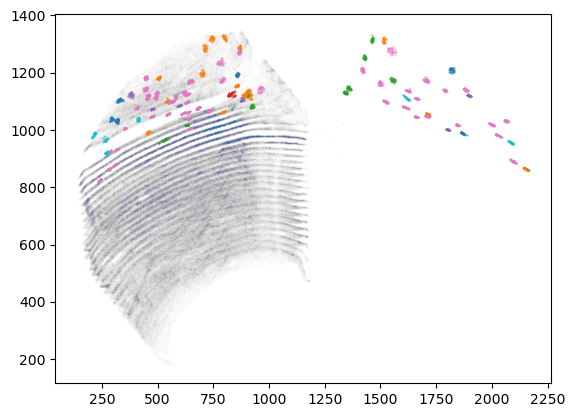

In [28]:
plt.scatter(adata.obsm['CCF_streamlines'][:, 0], adata.obsm['CCF_streamlines'][:, 1], s=0.1, alpha=0.01)
# Get dataloader
i=0
for batch in train_dataloader:
    color_idx = adata.obs['area_label'].cat.categories.tolist().index(batch['area_label'].cpu().numpy()[0])
    color = sns.color_palette("tab10", len(adata.obs['area_label'].cat.categories))[color_idx]
    plt.scatter(batch["CCF_streamlines"][0, :, 0].cpu(), batch["CCF_streamlines"][0, :, 1].cpu(), s=0.1, c=color)
    plt.scatter(batch["CCF_streamlines"][1, :, 0].cpu(), batch["CCF_streamlines"][1, :, 1].cpu(), s=0.1, c=color)
    i+=1

    if i>50:
        break